In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike
from matplotlib_venn import venn2
from matplotlib_venn import venn3

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)
both_rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('both_rewarded', 10, 10, plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [4]:
# Step 1: Concatenate the DataFrames
combined_df = pd.concat([win_df, lose_df, both_rewarded_df])

# Function to extract just the event name
def extract_event_name(event):
    # Splits the string and extracts the part before 'vs'
    return event.split(' vs ')[0].replace('10s ', '')

# Initialize an empty dictionary to hold aggregated data
aggregated_data = {}

# Iterate over the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    # Extract event name
    event_name = extract_event_name(row['Event'])
    # Construct a unique key for each combination of recording, subject, and unit id
    key = (row['Recording'], row['Subject'], row['original unit id'])
    
    # Initialize the entry if not exists
    if key not in aggregated_data:
        aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
    
    # Append the event name to the appropriate category based on 'event1 vs event2'
    if row['event1 vs event2'] == 'increases':
        aggregated_data[key]['sig_increase_events'].add(event_name)
    elif row['event1 vs event2'] == 'decreases':
        aggregated_data[key]['sig_decrease_events'].add(event_name)
    else:
        aggregated_data[key]['insig_events'].add(event_name)

# Convert the aggregated data into a DataFrame
rows = []
for (recording, subject, unit_id), categories in aggregated_data.items():
    row = {
        'Recording': recording,
        'Subject': subject,
        'original unit id': unit_id,
        'sig_increase_events': ', '.join(categories['sig_increase_events']),
        'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
        'insig_events': ', '.join(categories['insig_events']),
    }
    rows.append(row)

aggregated_df = pd.DataFrame(rows)

aggregated_df['sig_events'] = aggregated_df.apply(lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

# Function to normalize event strings
def normalize_event_string(event_string):
    event_list = event_string.split(', ')
    event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
    return ', '.join(event_list_sorted)  # Join the sorted list back into a string

# Apply the normalization function to the 'sig_events' column before counting
aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

# Count the unique combinations of significant events
sig_events_counts = aggregated_df['sig_events'].value_counts()

# Rename the empty strings to 'non-specific'
sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

In [5]:
aggregated_df

,Recording,Subject,original unit id,sig_increase_events,sig_decrease_events,insig_events,sig_events
0,20230622_110832_standard_comp_to_both_rewarded...,1-1,9,,,"lose, win, both_rewarded",
1,20230622_110832_standard_comp_to_both_rewarded...,1-1,24,,,"lose, win, both_rewarded",
2,20230622_110832_standard_comp_to_both_rewarded...,1-1,76,,,"lose, win, both_rewarded",
3,20230622_110832_standard_comp_to_both_rewarded...,1-1,10,both_rewarded,,"lose, win",both_rewarded
4,20230622_110832_standard_comp_to_both_rewarded...,1-1,94,,,"lose, win, both_rewarded",
...,...,...,...,...,...,...,...
116,20230625_112913_standard_comp_to_both_rewarded...,1-4,39,both_rewarded,,"lose, win",both_rewarded
117,20230625_112913_standard_comp_to_both_rewarded...,1-4,17,both_rewarded,,"lose, win",both_rewarded
118,20230625_112913_standard_comp_to_both_rewarded...,1-4,15,both_rewarded,,"lose, win",both_rewarded
119,20230625_112913_standard_comp_to_both_rewarded...,1-4,27,both_rewarded,,"lose, win",both_rewarded


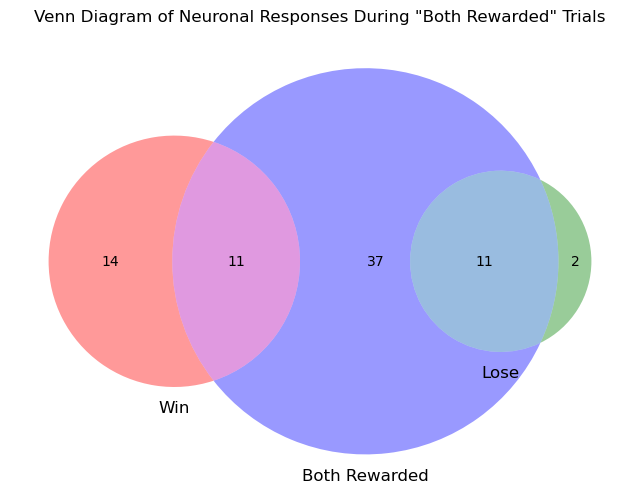

In [6]:
venn_data = {
    'Win Only': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Lose Only': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Win & Lose': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Both Rewarded Only': aggregated_df[(aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Win & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Lose & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win'))].shape[0],
    'Win, Lose, & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0]
}

# Define subsets for the Venn diagram (must be in a specific order)
# Order: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# Where A = Win, B = Lose, C = Both Rewarded
subsets = (
    venn_data['Win Only'],      # Win only
    venn_data['Lose Only'],     # Lose only
    venn_data['Win & Lose'],    # Win & Lose
    venn_data['Both Rewarded Only'], # Both Rewarded only
    venn_data['Win & Both Rewarded'],# Win & Both Rewarded
    venn_data['Lose & Both Rewarded'],# Lose & Both Rewarded
    venn_data['Win, Lose, & Both Rewarded'] # Win, Lose & Both Rewarded
)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(subsets=subsets, set_labels=('Win', 'Lose', 'Both Rewarded'))

# Display the plot
plt.title('Venn Diagram of Neuronal Responses During "Both Rewarded" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

In [7]:
sig_events_counts

sig_events
Non-Responsive         46
both_rewarded          37
win                    14
both_rewarded, lose    11
both_rewarded, win     11
lose                    2
Name: count, dtype: int64

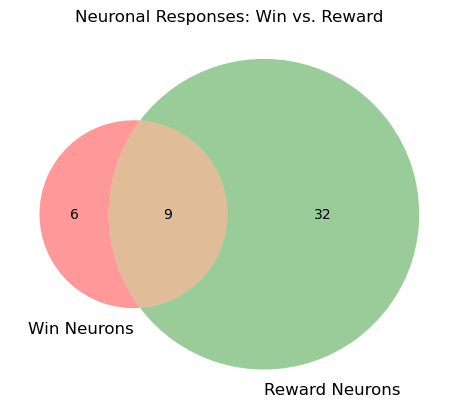

In [8]:
# Examples of other Venn Diagrams, but just directly inputting the data

win_neurons = 6
reward_neurons = 32
win_reward_overlap = 9

venn2(subsets=(win_neurons, reward_neurons, win_reward_overlap),
      set_labels=('Win Neurons', 'Reward Neurons'))

plt.title('Neuronal Responses: Win vs. Reward')
plt.show()
# plt.savefig('Win_Reward_Venn.png', bbox_inches='tight')

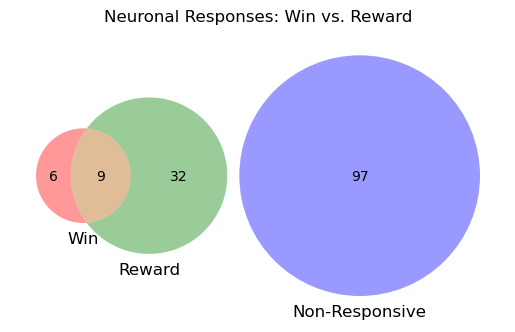

In [9]:
win_neurons = 6
reward_neurons = 32
win_reward_overlap = 9
non_responsive = 97

venn3(subsets = (6, 32, 9, 97, 0, 0, 0), set_labels = ('Win', 'Reward', 'Non-Responsive'))

plt.title('Neuronal Responses: Win vs. Reward')
plt.show()
# plt.savefig('Win_Reward_NR_Venn.png', bbox_inches='tight')

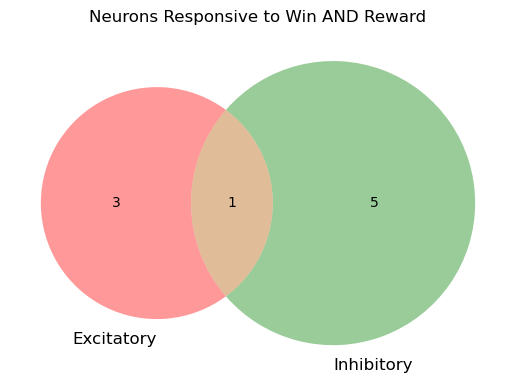

In [10]:
Win_Reward_Excitatory = 3
Win_Reward_Inhibitory = 5
Win_Reward_Diff = 1

venn2(subsets=(Win_Reward_Excitatory, Win_Reward_Inhibitory, Win_Reward_Diff),
      set_labels=('Excitatory', 'Inhibitory'))

plt.title('Neurons Responsive to Win AND Reward')
plt.show()
# plt.savefig('Win_Reward_Exc_Inh_Venn.png', bbox_inches='tight')

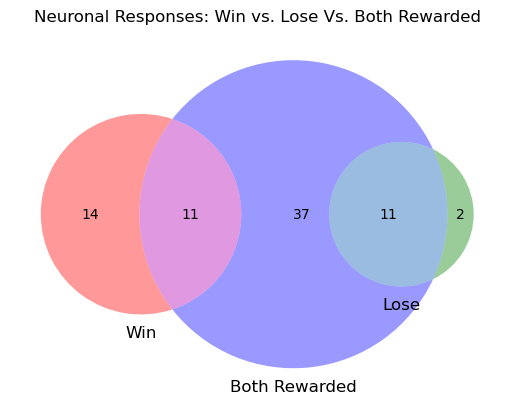

In [11]:
# (Abc, aBc, ABc, abC, AbC, aBC, ABC)

venn3(subsets = (14, 2, 0, 37, 11, 11, 0), set_labels = ('Win', 'Lose', 'Both Rewarded'))

plt.title('Neuronal Responses: Win vs. Lose Vs. Both Rewarded')
plt.show()
# plt.savefig('Win_Lose_BothReward_Venn.png', bbox_inches='tight')

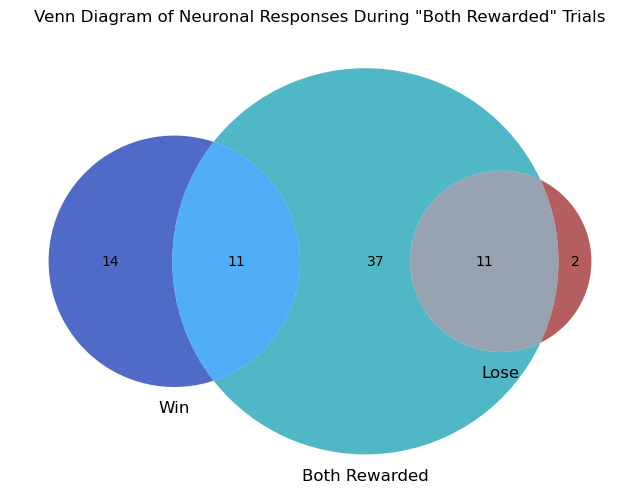

In [12]:
venn_data = {
    'Win Only': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Lose Only': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Win & Lose': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Both Rewarded Only': aggregated_df[(aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Win & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Lose & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win'))].shape[0],
    'Win, Lose, & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0]
}

# Define subsets for the Venn diagram (must be in a specific order)
# Order: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# Where A = Win, B = Lose, C = Both Rewarded
subsets = (
    venn_data['Win Only'],      # Win only
    venn_data['Lose Only'],     # Lose only
    venn_data['Win & Lose'],    # Win & Lose
    venn_data['Both Rewarded Only'], # Both Rewarded only
    venn_data['Win & Both Rewarded'],# Win & Both Rewarded
    venn_data['Lose & Both Rewarded'],# Lose & Both Rewarded
    venn_data['Win, Lose, & Both Rewarded'] # Win, Lose & Both Rewarded
)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(subsets=subsets, set_labels=('Win', 'Lose', 'Both Rewarded'), set_colors=('#042CB0', '#951a1d', '#0499af'), alpha=0.7)

# Display the plot
plt.title('Venn Diagram of Neuronal Responses During "Both Rewarded" Trials')
# plt.show()
plt.savefig('Both_Rewarded_Wilcox_NColors_Venn.png', bbox_inches='tight')

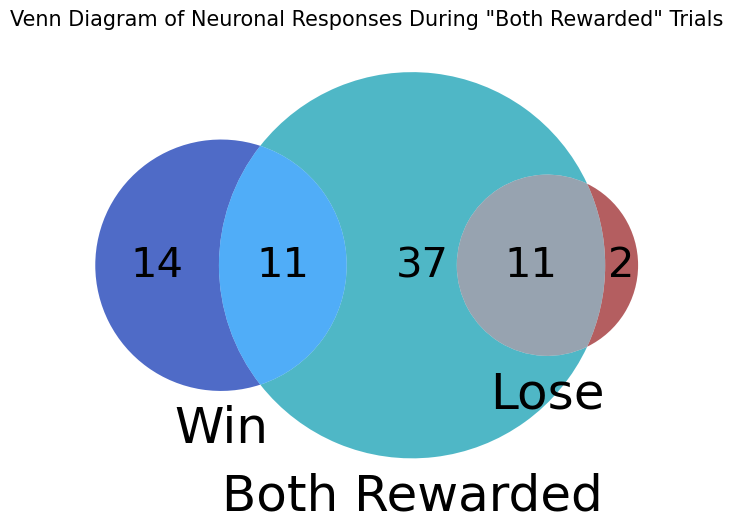

In [19]:
venn_data = {
    'Win Only': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Lose Only': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Win & Lose': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0],
    'Both Rewarded Only': aggregated_df[(aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Win & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Lose & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded') & ~aggregated_df['sig_events'].str.contains('win'))].shape[0],
    'Win, Lose, & Both Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('both_rewarded'))].shape[0]
}

# Define subsets for the Venn diagram (must be in a specific order)
# Order: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# Where A = Win, B = Lose, C = Both Rewarded
subsets = (
    venn_data['Win Only'],      # Win only
    venn_data['Lose Only'],     # Lose only
    venn_data['Win & Lose'],    # Win & Lose
    venn_data['Both Rewarded Only'], # Both Rewarded only
    venn_data['Win & Both Rewarded'],# Win & Both Rewarded
    venn_data['Lose & Both Rewarded'],# Lose & Both Rewarded
    venn_data['Win, Lose, & Both Rewarded'] # Win, Lose & Both Rewarded
)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
font1 = {'size':15}
font2 = {'size':30} # use for labels
plt.rc('font', **font2) # sets the default font 
venn = venn3(subsets=subsets, set_labels=('Win', 'Lose', 'Both Rewarded'), set_colors=('#042CB0', '#951a1d', '#0499af'), alpha=0.7)

# Display the plot
plt.title('Venn Diagram of Neuronal Responses During "Both Rewarded" Trials', fontdict=font1)
# plt.show()
plt.savefig('Both_Rewarded_Wilcox_NColors_3xFont_Venn.png', bbox_inches='tight')

In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike
from matplotlib_venn import venn2
from matplotlib_venn import venn3

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'omission'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
Please

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject
        
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [3]:
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)
rewarded_df = spike_analysis.wilcox_baseline_v_event_collection('rewarded', 10, 10, plot=False)

C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\short\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal ap

In [4]:
# Step 1: Concatenate the DataFrames
combined_df = pd.concat([win_df, lose_df, rewarded_df])

# Function to extract just the event name
def extract_event_name(event):
    # Splits the string and extracts the part before 'vs'
    return event.split(' vs ')[0].replace('10s ', '')

# Initialize an empty dictionary to hold aggregated data
aggregated_data = {}

# Iterate over the rows of the combined DataFrame
for index, row in combined_df.iterrows():
    # Extract event name
    event_name = extract_event_name(row['Event'])
    # Construct a unique key for each combination of recording, subject, and unit id
    key = (row['Recording'], row['Subject'], row['original unit id'])
    
    # Initialize the entry if not exists
    if key not in aggregated_data:
        aggregated_data[key] = {'sig_increase_events': set(), 'sig_decrease_events': set(), 'insig_events': set()}
    
    # Append the event name to the appropriate category based on 'event1 vs event2'
    if row['event1 vs event2'] == 'increases':
        aggregated_data[key]['sig_increase_events'].add(event_name)
    elif row['event1 vs event2'] == 'decreases':
        aggregated_data[key]['sig_decrease_events'].add(event_name)
    else:
        aggregated_data[key]['insig_events'].add(event_name)

# Convert the aggregated data into a DataFrame
rows = []
for (recording, subject, unit_id), categories in aggregated_data.items():
    row = {
        'Recording': recording,
        'Subject': subject,
        'original unit id': unit_id,
        'sig_increase_events': ', '.join(categories['sig_increase_events']),
        'sig_decrease_events': ', '.join(categories['sig_decrease_events']),
        'insig_events': ', '.join(categories['insig_events']),
    }
    rows.append(row)

aggregated_df = pd.DataFrame(rows)

aggregated_df['sig_events'] = aggregated_df.apply(lambda row: ', '.join(filter(None, [row['sig_increase_events'], row['sig_decrease_events']])), axis=1)

# Function to normalize event strings
def normalize_event_string(event_string):
    event_list = event_string.split(', ')
    event_list_sorted = sorted(event_list)  # Sort the list to ensure consistent order
    return ', '.join(event_list_sorted)  # Join the sorted list back into a string

# Apply the normalization function to the 'sig_events' column before counting
aggregated_df['sig_events'] = aggregated_df['sig_events'].apply(normalize_event_string)

# Count the unique combinations of significant events
sig_events_counts = aggregated_df['sig_events'].value_counts()

# Rename the empty strings to 'non-specific'
sig_events_counts = sig_events_counts.rename(index={'': 'Non-Responsive'})

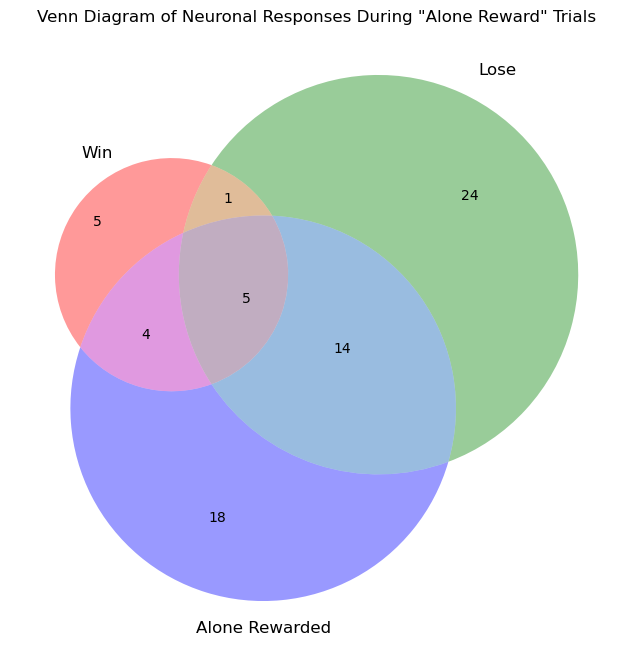

In [5]:
venn_data = {
    'Win Only': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('rewarded'))].shape[0],
    'Lose Only': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('rewarded'))].shape[0],
    'Win & Lose': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & ~aggregated_df['sig_events'].str.contains('rewarded'))].shape[0],
    'Rewarded Only': aggregated_df[(aggregated_df['sig_events'].str.contains('rewarded') & ~aggregated_df['sig_events'].str.contains('win') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Win & Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('rewarded') & ~aggregated_df['sig_events'].str.contains('lose'))].shape[0],
    'Lose & Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('rewarded') & ~aggregated_df['sig_events'].str.contains('win'))].shape[0],
    'Win, Lose, & Rewarded': aggregated_df[(aggregated_df['sig_events'].str.contains('win') & aggregated_df['sig_events'].str.contains('lose') & aggregated_df['sig_events'].str.contains('rewarded'))].shape[0]
}

# Define subsets for the Venn diagram (must be in a specific order)
# Order: (Abc, aBc, ABc, abC, AbC, aBC, ABC)
# Where A = Win, B = Lose, C = Rewarded
subsets = (
    venn_data['Win Only'],      # Win only
    venn_data['Lose Only'],     # Lose only
    venn_data['Win & Lose'],    # Win & Lose
    venn_data['Rewarded Only'], # Rewarded only
    venn_data['Win & Rewarded'],# Win & Rewarded
    venn_data['Lose & Rewarded'],# Lose & Rewarded
    venn_data['Win, Lose, & Rewarded'] # Win, Lose & Rewarded
)

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn3(subsets=subsets, set_labels=('Win', 'Lose', 'Alone Rewarded'))

# Display the plot
plt.title('Venn Diagram of Neuronal Responses During "Alone Reward" Trials')
plt.show()
# plt.savefig('Win_Lose_Reward_Wilcoxon_Venn.png', bbox_inches='tight')

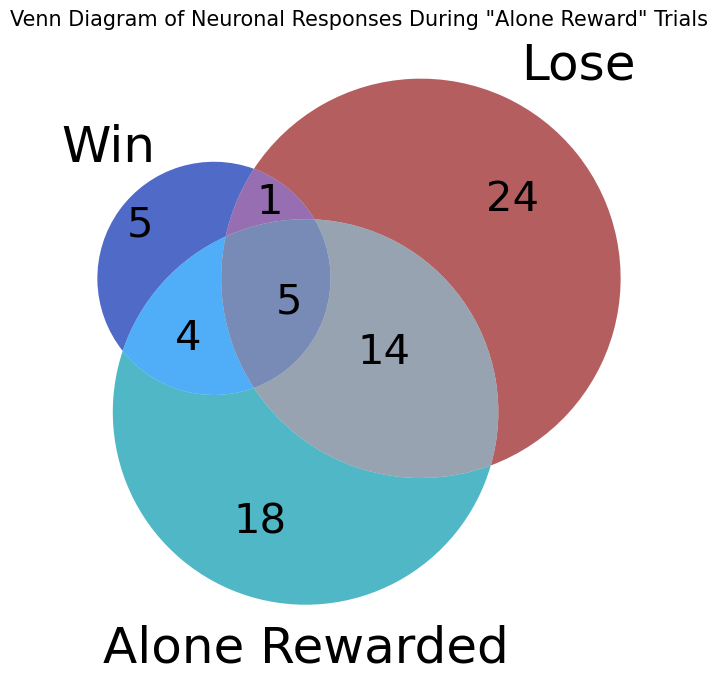

In [6]:
# Create the Venn diagram
plt.figure(figsize=(8, 8))
font1 = {'size':15}
font2 = {'size':30} # use for labels
plt.rc('font', **font2) # sets the default font 
venn = venn3(subsets=subsets, set_labels=('Win', 'Lose', 'Alone Rewarded'), set_colors=('#042CB0', '#951a1d', '#0499af'), alpha=0.7)

# Display the plot
plt.title('Venn Diagram of Neuronal Responses During "Alone Reward" Trials', fontdict=font1)
plt.show()
# plt.savefig('Alone_Rewarded_Wilcox_NColors_3xFont_Venn.png', bbox_inches='tight')